In [18]:
# Installing dependencies

!pip install opencv-python
!pip install tensorflow
!pip install requests
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import cv2
import numpy as np
import tensorflow as tf
import pathlib

In [2]:
def compress_image(image, format='jpg', quality=98):
    # Check the format and set the appropriate encoding parameters
    if format.lower() not in ('jpg', 'png', 'tif', 'tiff'):
        raise TypeError("Undefined type")
    if format.lower() == 'jpg':
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
        ext = '.jpg'
    elif format.lower() == 'png':
        encode_param = [int(cv2.IMWRITE_PNG_COMPRESSION), int((100 - quality) / 10)]
        ext = '.png'
    elif format.lower() in ['tiff', 'tif']:
        encode_param = [int(cv2.IMWRITE_TIFF_COMPRESSION), quality]  
        ext = '.tiff'
    else:
        raise ValueError("Unsupported format: {}".format(format))

    # Encode the image to the specified format
    success, encoded_image = cv2.imencode(ext, image, encode_param)
    if not success:
        raise RuntimeError("Image encoding failed")

    # Decode the image back to its original form
    compressed_image = cv2.imdecode(encoded_image, cv2.IMREAD_COLOR)
    return compressed_image


# Function to calculate the difference image
def calculate_difference_image(original_image, compressed_image):
    diff_image = cv2.absdiff(original_image, compressed_image)
    return diff_image

# Function to preprocess the image
def preprocess_image(image_path):
    # Load the forged image (F)
    original_image = cv2.imread(str(image_path))
    # original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # # Compress the image to get Fcomp
    compressed_image = compress_image(original_image, quality=98)

    # # Calculate Fdiff
    diff_image = calculate_difference_image(original_image, compressed_image)

    # Resize Fdiff to 160x160 pixels
    resized_diff_image = cv2.resize(diff_image, (160, 160))

    # Normalize the image
    normalized_diff_image = resized_diff_image / 255.0

    return normalized_diff_image

In [3]:

dataset_path = "/Users/logpoint/Documents/SoftwareProjects/Thesis/CASIA22"
data_dir = pathlib.Path(dataset_path)
images_dict = {
    'NonForged': list(data_dir.glob('Au/*')),
    'Forged': list(data_dir.glob('Tp/*')),
}


labels_dict = {
    'NonForged': 0,
    'Forged': 1
}

X, y = [], []

for label, images in images_dict.items():
    for image in images:        
        if image is None:
            print(f"Failed to load image: {image}")
            continue
        try:
            processed_image = preprocess_image(image)
        except Exception as e:
            print(image, "-------------------")
        X.append(processed_image)
        y.append(labels_dict[label])

X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

/Users/logpoint/Documents/SoftwareProjects/Thesis/CASIA22/Au/Thumbs.db -------------------
/Users/logpoint/Documents/SoftwareProjects/Thesis/CASIA22/Tp/Thumbs.db -------------------
/Users/logpoint/Documents/SoftwareProjects/Thesis/CASIA22/Tp/_list.txt -------------------
(12617, 160, 160, 3) (12617,)


In [4]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Load the MobileNetV2 model with pre-trained weights, excluding the top layers
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

# Freeze the convolutional base of the model to retain pre-trained weights during initial training
base_model.trainable = False

# Create the model architecture by adding custom layers on top of MobileNetV2
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Assuming you have preprocessed datasets ready: train_images and train_labels
# For example purposes, let's create dummy data
# train_images = np.random.rand(100, 160, 160, 3)
# train_labels = np.random.randint(2, size=(100, 1))

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

# Train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_images, train_labels,
                    validation_data=(test_images, test_labels),
                    epochs=40,
                    callbacks=[early_stopping])
# history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=5)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    32,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,552,321 (135.62 MB)

 Trainable params: 33,294,337 (127.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 87s 268ms/step - accuracy: 0.6924 - loss: 0.6650 - val_accuracy: 0.7979 - val_loss: 0.4652
Epoch 2/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 87s 276ms/step - accuracy: 0.7624 - loss: 0.5131 - val_accuracy: 0.8051 - val_loss: 0.4424
Epoch 3/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 90s 284ms/step - accuracy: 0.7851 - loss: 0.4758 - val_accuracy: 0.8130 - val_loss: 0.4267
Epoch 4/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 88s 279ms/step - accuracy: 0.8037 - loss: 0.4413 - val_accuracy: 0.8304 - val_loss: 0.4223
Epoch 5/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 88s 279ms/step - accuracy: 0.7989 - loss: 0.4474 - val_accuracy: 0.8288 - val_loss: 0.4042
Epoch 6/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 92s 292ms/step - accuracy: 0.8057 - loss: 0.4349 - val_accuracy: 0.8281 - val_loss: 0.4018
Epoch 7/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 107s 338ms/step - accuracy: 0.8198 - loss: 0.4132 - val_accuracy: 0.8451 - val_loss: 0.3863
Epoch 8/40
316/316 ━━━━━━━━━━━━━━━━━━━━ 129s 407ms/step - accuracy: 0.8224 - loss:

In [5]:
evaluation = model.evaluate(test_images, test_labels)

79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 229ms/step - accuracy: 0.8480 - loss: 0.3495


In [6]:
model.save('exported/model_8565_aug11_39epoch.h5')


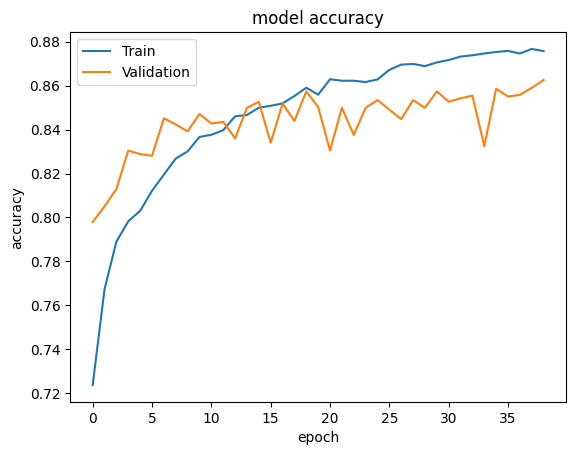

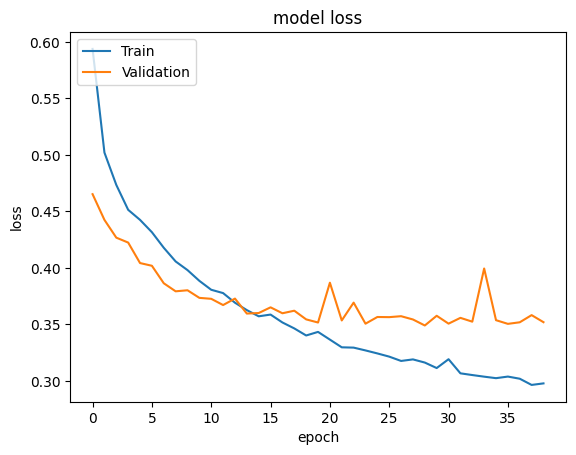

In [7]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
# image_path = 'IFD/archive/testdataset/Forged/f3.jpg'
# classify_image(model, image_path)

79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 235ms/step
Precision: 0.8168
Recall: 0.8129
F1 Score: 0.8149
              precision    recall  f1-score   support

   NonForged       0.87      0.88      0.87      1498
      Forged       0.82      0.81      0.81      1026

    accuracy                           0.85      2524
   macro avg       0.84      0.84      0.84      2524
weighted avg       0.85      0.85      0.85      2524



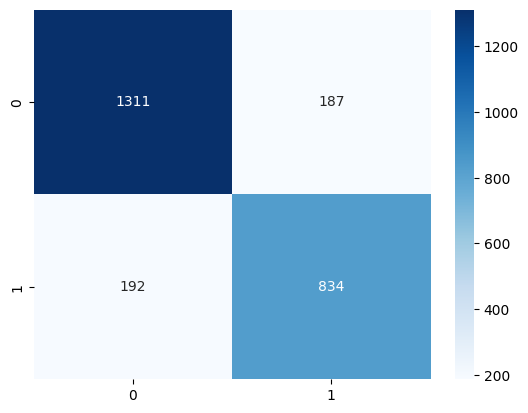

In [8]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Generate predictions
y_pred_probs = model.predict(test_images)
y_pred = (y_pred_probs > 0.5).astype(int) # Convert probabilities to binary predictions

# Calculate confusion matrix
cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

# Print the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Optionally, print a more detailed classification report
print(classification_report(test_labels, y_pred, target_names=['NonForged', 'Forged']))